# 1. Introduction

After scraping Berlin rent data and visualising it, I will take it a step further and build a predictive model estimating the square metre price of a flat.

The scraped data contains some useful features such as square metres, number of rooms etc. I will derive more features from the data that are available as well as change the format of the data. The feature 'Extra', for example, contains several key words delimited with a pipe, which is not useful for a predictive model. I will extract the key words and one-hot encode them so that they can be used.

My basic approach is to establish a baseline predictions, then use a RandomForest and add more features to it to test the effect of them on the predictions. At the end I use a more sophistcated algorithm, CatBoost, to come up with the final prediction.

I use two scores to assess the performance of my predictive model: Root Mean Squared Error (**RMSE**) and Mean Absolute Percentage Error (**MAPE**). RMSE shows by how many Euros the prediction is off on average and MAPE shows the same information but in percentage. I manage to increase the accuracy from an error of **4.50 Euros (28.7%)** to **2.58 Euros (15.1%)**. The way to further increase the accuracy of the prediction is to get hold of other datasets, in particular geographic data, such as distance to nearest metro station etc., which I won't be covering here though.

# 2. Load Data

In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import *

In [2]:
berlin_rent = pd.read_csv('C:/Users/Alessandro/Desktop/Scraping/Berlin/berlin_rent.csv', index_col=0)

# Delte some incorrect data
berlin_rent_adj = berlin_rent[berlin_rent['price_sqm'] < 50000].copy()

# Print the first few rows of the dataframe
berlin_rent_adj.head()

,address,rooms,area sqm,price,links,title,extra,postcode,price_sqm
0,"Schönstr.|Weißensee(Weißensee)|13086,Berlin",2.0,63.00,649.00,https://www.immobilienscout24.de/expose/109000100,Schön wohnen in Weißensee!,NaN,13086,10.301587
1,Kaiserdamm|Charlottenburg(Charlottenburg)|1405...,7.0,209.00,2799.00,https://www.immobilienscout24.de/expose/107708157,Herrschaftliche Wohnung im Westen Berlins,Balkon,14057,13.392344
2,QuedlinburgerStr.|Hellersdorf(Hellersdorf)|126...,3.0,62.53,387.94,https://www.immobilienscout24.de/expose/110171771,Hören Sie auf zu suchen. Hier ist Ihre neue Wo...,Balkon,12627,6.204062
3,LudwigsfelderStr.|Hellersdorf(Hellersdorf)|126...,3.0,69.40,525.18,https://www.immobilienscout24.de/expose/110171770,Zu Ostern in den neuen vier Wänden,Balkon,12629,7.567435
4,KöpenickerLandstraße|Plänterwald(Treptow)|1243...,2.0,51.67,419.91,https://www.immobilienscout24.de/expose/110171763,Zugreifen und Wohlfühlen,Balkon,12437,8.126766


# 3. EDA

In this section I get an overview of the features and their properties. This will also help me find outliers and incorrect data, which I will exclude.

## 3.1 Rooms

C:\Users\Alessandro\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


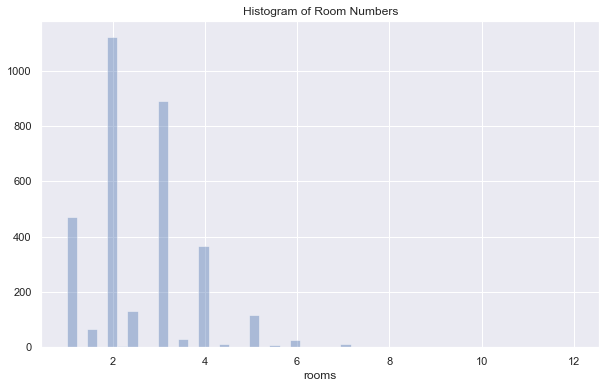

In [3]:
# Plot a histogram of the room number
plt.figure(figsize=(10,6))
sns.distplot(berlin_rent_adj['rooms'], kde=False)
plt.title('Histogram of Room Numbers')
plt.show()

In [4]:
# Get more stats
berlin_rent_adj['rooms'].describe()

count    3265.000000
mean        2.573109
std         1.153368
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        12.000000
Name: rooms, dtype: float64

## 3.2 Area Sqm

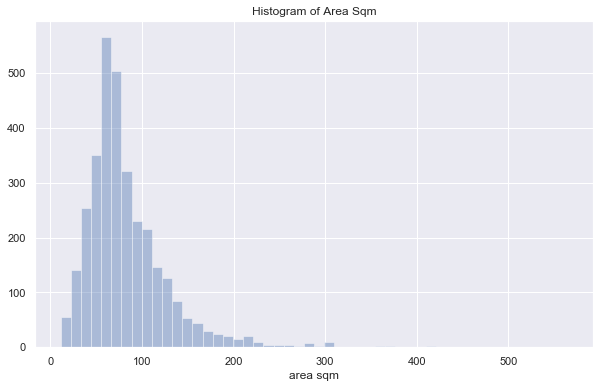

In [5]:
# Plot a histogram of area
plt.figure(figsize=(10,6))
sns.distplot(berlin_rent_adj['area sqm'], kde=False)
plt.title('Histogram of Area Sqm')
plt.show()

## 3.3 PostCode

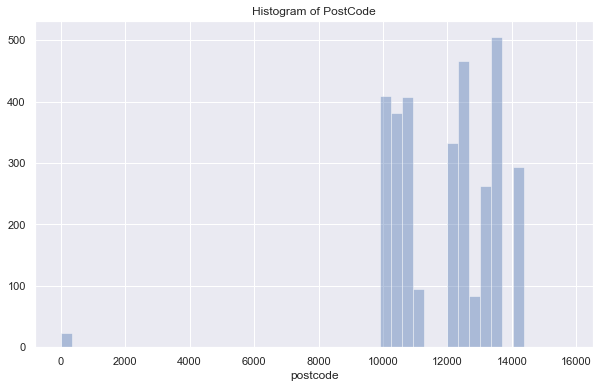

In [6]:
# Plot histogram of postal codes
plt.figure(figsize=(10,6))
sns.distplot(berlin_rent_adj['postcode'], kde=False)
plt.title('Histogram of PostCode')
plt.show()

In [7]:
# Get more stats
berlin_rent_adj['postcode'].describe()

count     3265.000000
mean     11933.851761
std       1701.635914
min          0.000000
25%      10623.000000
50%      12305.000000
75%      13189.000000
max      15732.000000
Name: postcode, dtype: float64

## 3.4 Square Metre Price Histogram

The red line is the mean square metre price and the black line the median square metre price.

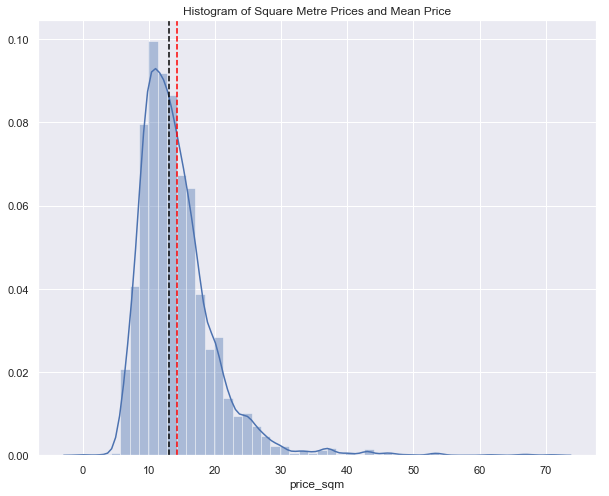

In [8]:
# Plot histogram of square metre price
plt.figure(figsize=(10,8))
sns.distplot(berlin_rent_adj['price_sqm'])
plt.axvline(x=np.mean(berlin_rent_adj['price_sqm']), color='red', linestyle='--')
plt.axvline(x=np.median(berlin_rent_adj['price_sqm']), color='black', linestyle='--')
plt.title('Histogram of Square Metre Prices and Mean Price');

In [9]:
# Get more stats
berlin_rent_adj['price_sqm'].describe()

count    3265.000000
mean       14.215180
std         5.878691
min         0.000000
25%        10.367211
50%        13.000000
75%        16.500423
max        70.952381
Name: price_sqm, dtype: float64

# 4. Prep Data

## 4.1 Delete Outliers

I am now going to delete outliers as they could affect the performance of the model.

In [10]:
# Delete outliers
berlin_rent_adj = berlin_rent_adj[(berlin_rent_adj['price_sqm']<30) & (berlin_rent_adj['price_sqm']>0)]
berlin_rent_adj = berlin_rent_adj[berlin_rent_adj['area sqm']<200]
berlin_rent_adj = berlin_rent_adj[berlin_rent_adj['postcode']>10000]
berlin_rent_adj = berlin_rent_adj[berlin_rent_adj['rooms']<6]

In [11]:
# Reset the index
berlin_rent_adj.reset_index(inplace=True)

# 5. Baseline

The baseline model, i.e. using the average square metre price, is on average off by 4.50 Euros (RMSE) or 28.7% (MAPE). I will compare any model against this baseline.

In [12]:
# Get average square metre price
price_avg = np.full(len(berlin_rent_adj),berlin_rent_adj['price_sqm'].mean())

# Calculate scores
rmse = np.sqrt(mean_squared_error(berlin_rent_adj['price_sqm'], price_avg))
mape = np.mean(np.abs((berlin_rent_adj['price_sqm'] - price_avg) / berlin_rent_adj['price_sqm']))

# Print scores
print('Baseline RMSE: ', np.round(rmse,3))
print('Baseline MAPE: ', np.round(mape,3))

Baseline RMSE:  4.5
Baseline MAPE:  0.288


# 6. Derive features

In order to run a model I need to convert some data into a different format and also create new features. This is what I am going to do in this section.

I will do the following:

- Calculate the average square metre price and its standard deviation per postal code. I do this at two granularity levels of the postal code.
- I extract and reformat in the information contained in Extras. The features conatins 'garden', 'kitchen', and 'balcony'. I will one-hot encode them.
- The feature Title contains free text. I use WordCloud as well as additional key words I observed to create new features.
- I then update the data type so that they can be used in the model.

## 6.1 Average and Standard Deviation of Square Metre Price by PostCode

Let's start off by calculating the average square metre price of each postcode. I will do this at two granularity levels in case using the most granular postcode leads to overfitting.

### 6.1.1 Using the 5-digit PostCode

In [13]:
# Calculate the average square metre price per 5-digit post code
postcode5_avg_rent = berlin_rent_adj[['postcode', 'price_sqm']].groupby(by='postcode')['price_sqm'].mean().reset_index()
postcode5_avg_rent['price_sqm'] = np.round(postcode5_avg_rent['price_sqm'],2)

# Calculate the standard deviation of the square metre price per 5-digit post code
postcode5_std_rent = berlin_rent_adj[['postcode', 'price_sqm']].groupby(by='postcode')['price_sqm'].std().reset_index()
postcode5_std_rent['price_sqm'] = np.round(postcode5_std_rent['price_sqm'],2)

# Rename the column
postcode5_avg_rent.rename(columns={'price_sqm': 'postcode5_avg_price'}, inplace=True)
postcode5_std_rent.rename(columns={'price_sqm': 'postcode5_std_price'}, inplace=True)

# Replace stadard deviation = NaN with 0
postcode5_std_rent.loc[postcode5_std_rent['postcode5_std_price'].isna(),'postcode5_std_price'] = 0

# Show the first few lines
print(postcode5_avg_rent.head())
print(postcode5_std_rent.head())

   postcode  postcode5_avg_price
0     10115                17.79
1     10117                19.05
2     10119                19.57
3     10147                21.02
4     10178                18.33
   postcode  postcode5_std_price
0     10115                 3.55
1     10117                 3.71
2     10119                 4.50
3     10147                 0.00
4     10178                 3.34


### 6.1.2 Using the 4-digit PostCode

In [14]:
# Get the 4-digit postcode
berlin_rent_adj['postcode_4dig'] = np.floor(berlin_rent_adj['postcode'] / 10)

# Calculate the average square metre price per 4-digit post code
postcode4_avg_rent = berlin_rent_adj[['postcode_4dig', 'price_sqm']].groupby(by='postcode_4dig')['price_sqm'].mean().reset_index()
postcode4_avg_rent['price_sqm'] = np.round(postcode4_avg_rent['price_sqm'],2)

# Calculate the standard deviation of the square metre price per 4-digit post code
postcode4_std_rent = berlin_rent_adj[['postcode_4dig', 'price_sqm']].groupby(by='postcode_4dig')['price_sqm'].std().reset_index()
postcode4_std_rent['price_sqm'] = np.round(postcode4_std_rent['price_sqm'],2)

# Rename the column
postcode4_avg_rent.rename(columns={'price_sqm': 'postcode4_avg_price'}, inplace=True)
postcode4_std_rent.rename(columns={'price_sqm': 'postcode4_std_price'}, inplace=True)

# Replace stadard deviation = NaN with 0
postcode4_std_rent.loc[postcode4_std_rent['postcode4_std_price'].isna(),'postcode4_std_price'] = 0

# Show the first few lines
print(postcode4_avg_rent.head())
print(postcode4_std_rent.head())

   postcode_4dig  postcode4_avg_price
0         1011.0                18.58
1         1014.0                21.02
2         1017.0                18.48
3         1024.0                16.15
4         1031.0                12.52
   postcode_4dig  postcode4_std_price
0         1011.0                 3.84
1         1014.0                 0.00
2         1017.0                 3.34
3         1024.0                 3.65
4         1031.0                 3.23


### 6.1.3 Join the two Tables back to the DataFrame

In [15]:
# Join average rent
berlin_rent_adj = berlin_rent_adj.merge(right=postcode5_avg_rent, how='inner', on='postcode')
berlin_rent_adj = berlin_rent_adj.merge(right=postcode4_avg_rent, how='inner', on='postcode_4dig')

# Join standard deviation of rent
berlin_rent_adj = berlin_rent_adj.merge(right=postcode5_std_rent, how='inner', on='postcode')
berlin_rent_adj = berlin_rent_adj.merge(right=postcode4_std_rent, how='inner', on='postcode_4dig')

## 6.2 Find the unique Extras

The column Extras contains additional features of the flat. Each feature is delimited by a pipe. I must first separate the individual extras and then one-hot encode them so that I can use them in the model.

In [16]:
# get all Extra values that are not null
extra = pd.Series(berlin_rent_adj[~berlin_rent_adj['extra'].isna()]['extra']).reset_index().drop('index', axis=1)

# get everything in the right format
extra = extra.iloc[:, 0]

# extract the individual words
extra_attributes = [re.findall('\w+', extra.loc[i]) for i in np.arange(len(extra))]
   
# seperate everything and flatten the list    
flat = [x for sub_list in extra_attributes for x in sub_list]

# get the unique values
attributes = np.unique(flat)

In [17]:
# create Series with booleans whether or a not an extra exists in that partciular flat
balcony = pd.Series([np.isin(berlin_rent_adj.loc[i,'extra'], attributes[0]) for i in np.arange(len(berlin_rent_adj))])
kitchen = pd.Series([np.isin(berlin_rent_adj.loc[i,'extra'], attributes[1]) for i in np.arange(len(berlin_rent_adj))])
garden = pd.Series([np.isin(berlin_rent_adj.loc[i,'extra'], attributes[2]) for i in np.arange(len(berlin_rent_adj))])

C:\Users\Alessandro\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
# add those Series to the general dataframe
berlin_rent_adj['balcony'] = balcony
berlin_rent_adj['kitchen'] = kitchen
berlin_rent_adj['garden'] = garden

# Change dtype
berlin_rent_adj['balcony'] = berlin_rent_adj['balcony'].astype('bool')
berlin_rent_adj['kitchen'] = berlin_rent_adj['kitchen'].astype('bool')
berlin_rent_adj['garden'] = berlin_rent_adj['garden'].astype('bool')

## 6.3 Title

The column Title contains a free text. I will extract some of the most commonly use words in the text using wordcloud as well some other key words that I can identify from reading through the text.

### 6.3.1 WordCloud

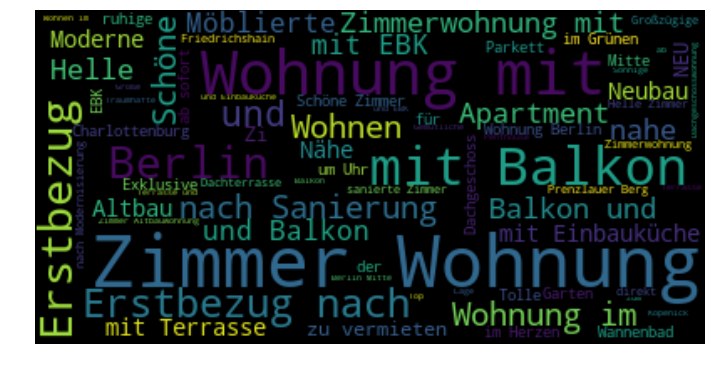

In [19]:
# Join all the text together so that it can be processed with wordcloud
text = " ".join(text for text in berlin_rent_adj['title'])

# Generate the wordcloud
wordcloud = WordCloud().generate(text)

# Display the wordcloud
plt.figure(figsize=(12,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 6.3.2 Key Words

These are the key words I will be using.

In [20]:
key_words = ['furnished', 'möbliert', 'shared', 'cleaning', 'wifi', 'altbau', 
             'concierge', 'loggia', 'fußbodenheizung', 'ebk', 'terrasse', 'dachgeschoss',
            'neubau', 'saniert', 'sanierung', 'luxus', 'modernisiert', 'renovierung', 'erstbezug']

### 6.3.3 Extract Key Words and One-Hot Encode

In [21]:
# Create empty DataFrame in which I will insert the one-hot encoded data
title = pd.DataFrame(columns=key_words) # keywords available in section wordcloud
title

,furnished,möbliert,shared,cleaning,wifi,altbau,concierge,loggia,fußbodenheizung,ebk,terrasse,dachgeschoss,neubau,saniert,sanierung,luxus,modernisiert,renovierung,erstbezug


In [22]:
# Search for each key word in 'title'
for i in np.arange(len(key_words)):
    keyword_regex = re.compile(key_words[i], re.IGNORECASE)
    
# write into DataFrame whether or not the key word can be found at each index in 'title': 1=yes, 0=no
    for j in np.arange(len(berlin_rent_adj)):
        if re.findall(keyword_regex, berlin_rent_adj['title'][j]) == []:
            title.at[j, key_words[i]] = 0
        else: title.at[j, key_words[i]] = 1
            
# Display the result
title.head()

,furnished,möbliert,shared,cleaning,wifi,altbau,concierge,loggia,fußbodenheizung,ebk,terrasse,dachgeschoss,neubau,saniert,sanierung,luxus,modernisiert,renovierung,erstbezug
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 6.3.4 Merge some Keywords

Some key words are synonyms of each other. At the same time the same word can appear in German or in English in the text. I will combine the keywords in such case. 

In [23]:
# Merge 'furnished' and 'möbliert'
furnished = pd.DataFrame((np.array(title['furnished']) == 1) | (np.array(title['möbliert']) == 1))

# Merge synonyms for 'renovated'
renovated = pd.DataFrame((np.array(title['saniert']) == 1) | (np.array(title['sanierung']) == 1) | \
(np.array(title['renovierung']) == 1) | (np.array(title['modernisiert']) == 1))

### 6.3.5 Update DataFrame 'title'

In [24]:
# Delete the synonyms
title.drop(['furnished', 'möbliert', 'saniert', 'sanierung', 'renovierung', 'modernisiert'], 
           axis=1, inplace=True)

# Add the merged features
title['renovated'] = renovated
title['furnished'] = furnished

# Look at first few lines
title.head()

,shared,cleaning,wifi,altbau,concierge,loggia,fußbodenheizung,ebk,terrasse,dachgeschoss,neubau,luxus,erstbezug,renovated,furnished
0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False
1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False
2,0,0,0,0,0,0,0,0,0,0,0,0,1,False,False
3,0,0,0,0,0,0,0,0,0,0,1,0,1,False,False
4,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False


### 6.3.6 Join Title to DataFrame

In [25]:
berlin_rent_adj = pd.concat([berlin_rent_adj, title], axis=1)

## 6.4 Update DataTypes

In [26]:
# Update which features should be categorical
cat_features = ['balcony', 'kitchen', 'garden', 'shared', 'cleaning', 'wifi', 'altbau', 
               'concierge', 'loggia', 'fußbodenheizung', 'ebk', 'terrasse', 'dachgeschoss',
               'neubau', 'luxus', 'erstbezug', 'renovated', 'furnished']

for i in cat_features:
    berlin_rent_adj[i] = berlin_rent_adj[i].astype('category')
    berlin_rent_adj[i] = berlin_rent_adj[i].cat.codes

# 7. New Feature Analysis

It's now time to expect the new features that I created to get an idea whether or not they could be useful in the model. A lot of the features from Text do not appear very often. I will not use the features that are used very rarely as it might lead to overfitting or is just plain redundant. This is certainly true for: 'shared', 'cleaning', 'wifi', 'concierge', 'loggia', 'fußbodenheizung'.

## 7.1 Average Square Metre Price by PostCode

C:\Users\Alessandro\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


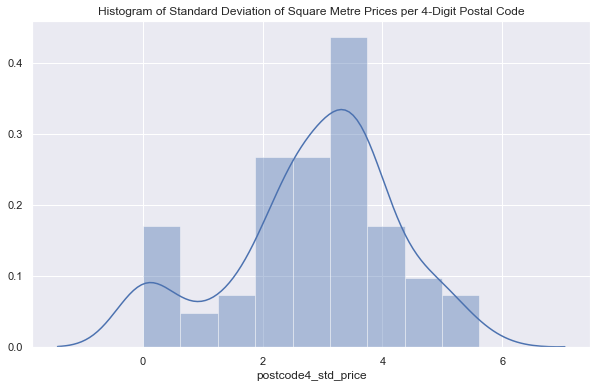

In [27]:
# Plot a histogram of the square metre price standard deviation per 4-digit postal code
plt.figure(figsize=(10,6))
sns.distplot(postcode4_std_rent['postcode4_std_price'])
plt.title('Histogram of Standard Deviation of Square Metre Prices per 4-Digit Postal Code')
plt.show()

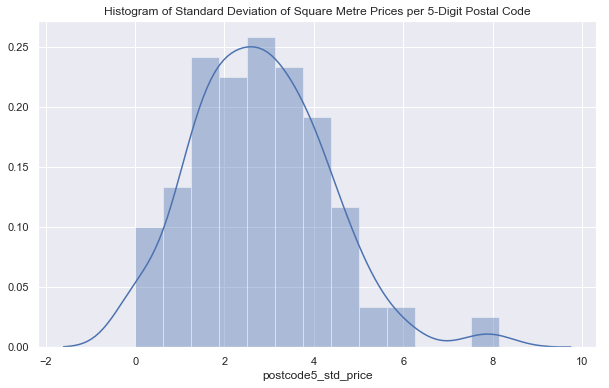

In [29]:
# Plot a histogram of the square metre price standard deviation per 5-digit postal code
plt.figure(figsize=(10,6))
sns.distplot(postcode5_std_rent['postcode5_std_price'])
plt.title('Histogram of Standard Deviation of Square Metre Prices per 5-Digit Postal Code')
plt.show()

## 7.2 Extras

In [30]:
# Get percentage of flats containing the features
berlin_rent_adj[['balcony', 'kitchen', 'garden']].mean()

balcony    0.271104
kitchen    0.105195
garden     0.008442
dtype: float64

## 7.3 Title

In [31]:
# Get percentage of flats containing the features
title.mean()

shared             0.000325
cleaning           0.000000
wifi               0.000000
altbau             0.086364
concierge          0.002273
loggia             0.007468
fußbodenheizung    0.005519
ebk                0.071104
terrasse           0.093182
dachgeschoss       0.057143
neubau             0.053896
luxus              0.011364
erstbezug          0.157792
renovated          0.158442
furnished          0.077922
dtype: float64

# 8. Random Forest - Basic Data

I will run a simple Random Forest with the original unprocessed data and capture the RMSE, MAPE, and also plot where erros occur - are more expensiv or cheaper flats less predictable?

The **RMSE is 3.16** and **MAPE is 17.6%**, which is a big improvement over the baseline but not great. There seem to be a handful of expensive flats that the model seriously underpredicted and a few cheap flats that the model overpredicted. This is indicated by the distance from the diagonal line in the plot.

## 8.1 Prep Data

In [32]:
# Split up into dependent and independent data
X = berlin_rent_adj[['rooms', 'area sqm', 'postcode']]
y = berlin_rent_adj['price_sqm']

In [33]:
# Split in training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

## 8.2 Run the Model

In [34]:
# Set up the model
rf = RandomForestRegressor(n_estimators=100)

# Run the model and make predictions
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

## 8.3 Calculate the Score

In [35]:
# Calculate scores
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mape = np.mean(np.abs((y_val - y_pred) / y_val))

# Print scores
print('RMSE: ', np.round(rmse,3))
print('MAPE: ', np.round(mape,3))

Baseline RMSE:  3.155
Baseline MAPE:  0.176


## 8.4 Evaluation

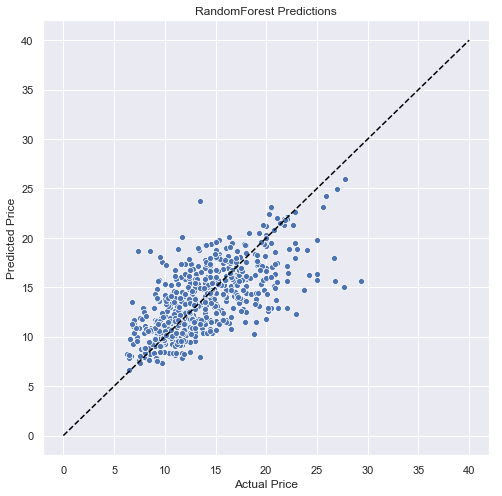

In [36]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(y_val, y_pred)
plt.plot([0,40], [0,40], linestyle='--', color='black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('RandomForest Predictions')
plt.show()

# 9. Random Forest - Augmented Data

Using the additional features that I created the **RMSE has further improved to 2.75** and **MAPE to 15.1%**. 

## 9.1 Prep Data

In [37]:
# Split up into dependent and independent data
X = berlin_rent_adj.drop(['price_sqm', 'price', 'address', 'links', 'title', 'extra', 'index'], axis=1)
y = berlin_rent_adj['price_sqm']

In [38]:
# Split in training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

## 9.2 Run the Model

In [39]:
# Set up the model
rf = RandomForestRegressor(n_estimators=100)

# Run the model and make predictions
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

## 9.3 Calculate the Score

In [40]:
# Calculate scores
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mape = np.mean(np.abs((y_val - y_pred) / y_val))

# Print scores
print('RMSE: ', np.round(rmse,3))
print('MAPE: ', np.round(mape,3))

Baseline RMSE:  2.745
Baseline MAPE:  0.151


## 9.4 Evaluation

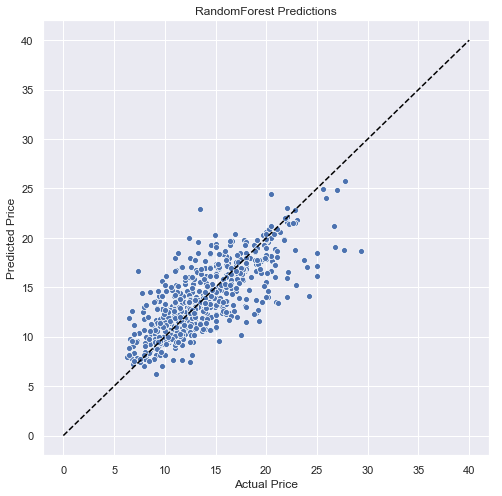

In [41]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(y_val, y_pred)
plt.plot([0,40], [0,40], linestyle='--', color='black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('RandomForest Predictions')
plt.show()

# 10. CatBoost

After having established that using additional features greatly improves the scores, it is now time to use a more sophisticated model, CatBoost, to get the final prediction, which is an **RMSE of 2.58** and a **MAPE of 15.1%**.

## 10.1 Prep Data

In [42]:
# Split up into dependent and independent data
X = berlin_rent_adj.drop(['price_sqm', 'price', 'address', 'links', 'title', 'extra', 'index'], axis=1)
y = berlin_rent_adj['price_sqm']

In [43]:
# Split in training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Change the data to 'pool' data for CatBoost, which is more memory efficent 
pool_train = Pool(data=X_train, label=y_train)
pool_val = Pool(data=X_val, label=y_val)

## 10.2 Run the Model

In [44]:
# Set up the model and define its parameters
cat = CatBoostRegressor(
    random_seed=1)

# Fit the model
cat.fit(
    pool_train,
    cat_features=None,
    eval_set=(pool_val),
    logging_level='Silent',
    plot=True
)

# Make predictions
y_pred = cat.predict(X_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## 10.3 Calculate the Score

In [45]:
# Calculate scores
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mape = np.mean(np.abs((y_val - y_pred) / y_val))

# Print scores
print('RMSE: ', np.round(rmse,3))
print('MAPE: ', np.round(mape,3))

RMSE:  2.586
MAPE:  0.151


## 10.4 Evaluation

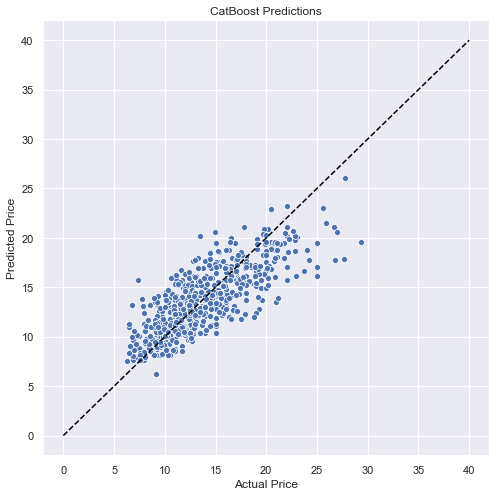

In [46]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(y_val, y_pred)
plt.plot([0,40], [0,40], linestyle='--', color='black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('CatBoost Predictions')
plt.show()